In [10]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os


In [11]:
#Set path to data
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
# path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/RNA_concat_lipids.h5ad"


In [12]:
# Set task/dataset name and path to store (keep MSI since it will be used for storing)
dataset_name  = "V11L12-038_A1.MSI_MOSCOT_paired_hvg"
store_dir = "/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/"
# name of final data will be a combination of task_name and topN abundant metabs

In [13]:
adata_msi_full = sc.read_h5ad(path_msi)
# adata_rna_full = sc.read_h5ad(path_rna)

### Prepare MSI data

In [14]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [15]:
adata_msi_full.var_names_make_unique()

In [16]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()

In [17]:
adata_msi_full.var_names

Index(['137.023795', '154.026815', '162.11293999999998', '169.07619',
       '169.076575', '170.07992000000002', '170.08429999999998', '171.09223',
       '176.00807', '176.00849',
       ...
       '968.5382649999999', '968.564535', '969.56285', '973.551305',
       '980.533075', '981.582135', '982.519885', '983.879985', '985.53971',
       '989.5183649999999'],
      dtype='object', length=500)

In [ ]:
# adata_msi = adata_msi_full[:, adata_msi_full.var_names.astype(float) > 288.15].copy()


In [19]:
adata_msi = adata_msi_full.copy()

In [20]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Quality control

In [1]:
# sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

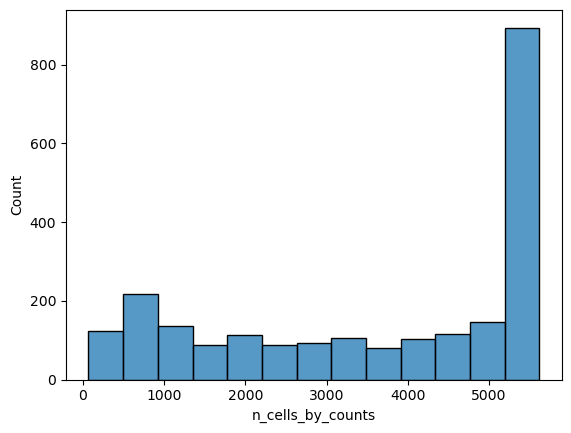

In [ ]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
adata_msi.var.n_cells_by_counts.describe()

# we notice that o

### Let's identify most spatialy variable metabolites

In [21]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

MoranI already present, but just for completeness let's go for the procedure from beginning



In [22]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


Do a sorting based first on index, then on Benjamini Hochberg FDR correction pvalue and select the top 30

In [23]:
adata_msi.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
203.05299000000002,0.728759,0.000000,0.000113,0.000000
162.11293999999998,0.720096,0.000000,0.000113,0.000000
214.01164,0.692849,0.000000,0.000113,0.000000
280.092375,0.690487,0.000000,0.000113,0.000000
845.51016,0.678208,0.000000,0.000113,0.000000
...,...,...,...,...
757.524185,-0.012857,0.120397,0.000113,0.131438
955.885645,-0.013307,0.112128,0.000113,0.122678
985.53971,-0.015396,0.079038,0.000113,0.087626
889.700055,-0.016634,0.063264,0.000113,0.070924


In [24]:
top_30_spat = adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_values(by=["I", "pval_norm_fdr_bh"], ascending=[False, True]).index[:30]


Mini correction for known matrix peaks, select matrix and mode


In [25]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([137.023795, 154.026815, 162.11294 , 169.07619 , 169.076575,
       170.07992 , 170.0843  , 171.09223 , 176.00807 , 176.00849 ,
       177.01202 , 184.073665, 192.910475, 195.09167 , 195.09231 ,
       196.09551 , 196.099945, 197.990325, 198.089485, 198.997635,
       198.99817 , 198.99861 , 203.05299 , 206.055125, 209.956945,
       213.964855, 214.01164 , 223.03314 , 225.970665, 236.99253 ,
       240.122615, 245.044795, 250.092675, 250.09344 , 251.96655 ,
       251.9674  , 268.104005, 269.107645, 273.03447 , 273.03932 ,
       274.036065, 274.036655, 274.04128 , 274.041785, 274.042885,
       274.04389 , 274.04675 , 275.04461 , 275.045965, 275.054015,
       275.05495 , 275.055885, 275.066305, 280.092375, 282.27948 ,
       287.054975, 289.03455 , 290.04088 , 290.041915, 290.04295 ,
       291.04627 , 291.048925, 291.04997 , 291.975255, 292.053015,
       292.05779 , 293.065595, 295.02107 , 295.022045, 296.065955,
       297.048175, 297.06824 , 297.070615, 298.065095, 299.305

In [26]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))

# dhb_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_positive[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


# fmp10_peaks_negative = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
# found_peaks = set(mz_values[np.abs(mz_values[:, None] - fmp10_peaks_negative[None, :]).min(axis=1) <= 0.1])
# found_peaks_str = set(map(str, found_peaks))


In [27]:
found_peaks

{np.float64(137.023795),
 np.float64(177.01202),
 np.float64(273.03447),
 np.float64(273.03932)}

In [28]:
top_30_spat_filtered = [mz for mz in top_30_spat if mz not in found_peaks_str]
print(top_30_spat_filtered, len(top_30_spat_filtered))

['203.05299000000002', '162.11293999999998', '214.01164', '280.092375', '845.51016', '251.9674', '353.023935', '251.96654999999998', '617.9799350000001', '297.070615', '176.00849', '296.06595500000003', '806.564065', '313.031765', '820.5117700000001', '754.579975', '198.99817000000002', '872.54763', '240.122615', '198.997635', '312.02405999999996', '848.55056', '313.03045', '206.055125', '873.544905', '735.566455', '313.033195', '804.551205', '297.06824', '753.587535'] 30


In [29]:
# ['203.05299000000002',
#  '162.11293999999998',
#  '214.01164',
#  '280.092375',
#  '845.51016',
#  '251.9674',
#  '353.023935',
#  '251.96654999999998',
#  '617.9799350000001',
#  '297.070615']

In [ ]:
top_5_spat_metabolites = top_30_spat_filtered[:5]
top_10_spat_metabolites = top_30_spat_filtered[:10]
top_20_spat_metabolites = top_30_spat_filtered[:20]
# adata_msi_top5_spat = adata_msi[:, adata_msi.var_names.isin(top_5_spat_metabolites)].copy()
adata_msi_top10_spat = adata_msi[:, adata_msi.var_names.isin(top_10_spat_metabolites)].copy()
adata_msi_top20_spat = adata_msi[:, adata_msi.var_names.isin(top_20_spat_metabolites)].copy()



In [31]:
os.path.join(store_dir, f"{dataset_name}_top20spatvar.h5ad")

'/lustre/groups/ml01/workspace/eirini.giannakoulia/hand_prep/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top20spatvar.h5ad'

In [32]:
# adata_msi_top5_spat.write(os.path.join(store_dir, f"{dataset_name}_top5spatvar.h5ad"))
adata_msi_top10_spat.write(os.path.join(store_dir, f"{dataset_name}_top10spatvar.h5ad"))
adata_msi_top20_spat.write(os.path.join(store_dir, f"{dataset_name}_top20spatvar.h5ad"))

In [33]:
# adata_msi_top5_spat

To use in big pipeline split in train and test

In [46]:
task_name = "V11L12-038_A1_MOSCOT_paired_hvg"
split = "split"

In [47]:
# base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top5_spatvar"
# adata_msi_top5_spat_train = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "train"].copy()
# adata_msi_top5_spat_test = adata_msi_top5_spat[adata_msi_top5_spat.obs["half_split" ]== "test"].copy()

# for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
#     adata_msi_top5_spat_train.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_train.h5ad"))
#     adata_msi_top5_spat_test.write(os.path.join("/lustre/groups/ml01/workspace/eirini.giannakoulia/lipids_top5_spatvar",feat_sel,"msi_dataset_test.h5ad"))


In [48]:
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top10_spatvar"
adata_msi_top10_spat_train = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="train"].copy()
adata_msi_top10_spat_test = adata_msi_top10_spat[adata_msi_top10_spat.obs[split]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    # Create the directory if it doesn't exist
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)

    # Write the files
    adata_msi_top10_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top10_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


In [50]:
adata_msi_top10_spat

AnnData object with n_obs × n_vars = 2681 × 10
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [53]:
adata_msi_top20_spat_train

AnnData object with n_obs × n_vars = 2144 × 20
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [51]:
base_dir = f"/lustre/groups/ml01/workspace/eirini.giannakoulia/{task_name}_top20_spatvar"

adata_msi_top20_spat_train = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="train"].copy()
adata_msi_top20_spat_test = adata_msi_top20_spat[adata_msi_top20_spat.obs[split]=="test"].copy()

for feat_sel in ["hvg", "hvg_svd", "hvg_svd_graph", "svd", "svd_graph"]:
    out_dir = os.path.join(base_dir, feat_sel)
    os.makedirs(out_dir, exist_ok=True)
    
    adata_msi_top20_spat_train.write(os.path.join(out_dir, "msi_dataset_train.h5ad"))
    adata_msi_top20_spat_test.write(os.path.join(out_dir, "msi_dataset_test.h5ad"))


In [62]:
out_dir = "V11L12-038_A1_MOSCOT_paired_hvg_top10_spatvar"

In [63]:
sc.read_h5ad(f"/lustre/groups/ml01/workspace/eirini.giannakoulia/pipeline/dataset/processed/{out_dir}/hvg/msi_dataset_train.h5ad")

AnnData object with n_obs × n_vars = 2144 × 10
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'